# 📚 Imports
---

In [74]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import collections

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 📖 Data
---

In [75]:
df = pd.read_csv('data/mental_health.csv')

In [76]:
df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27977 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27977 non-null  object
 1   label   27977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.3+ KB


In [78]:
df['label'].value_counts()

0    14139
1    13838
Name: label, dtype: int64

# ♻️ Text data pre-processing
---

In [79]:
# Variavel para substituir todos os caracteres que não são letras ou espaços em branco
regex = re.compile('[^a-z\s]')
# Transforma o texto em minusculo
df['clean_text'] = df['text'].str.lower()
# Remove todos os caracteres que não são letras ou espaços 
df['clean_text'] = df['clean_text'].apply(lambda x: regex.sub('', x))
# Remove palavras com menos de 3 caracteres
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [80]:
# Tokenization
df['clean_text'] = df['clean_text'].apply(word_tokenize)

# Removing stopwords
stop_words = set(stopwords.words('english'))
df['clean_text'] = df['clean_text'].apply(lambda x: [word for word in x if word not in stop_words])

# Word normalization
stemmer = SnowballStemmer('english')
df['clean_text'] = df['clean_text'].apply(lambda x: [stemmer.stem(word) for word in x])

# Joining the words back into a single text
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(x))

# 📊 Top 10 most used words
---

Text(0, 0.5, 'Frequency')

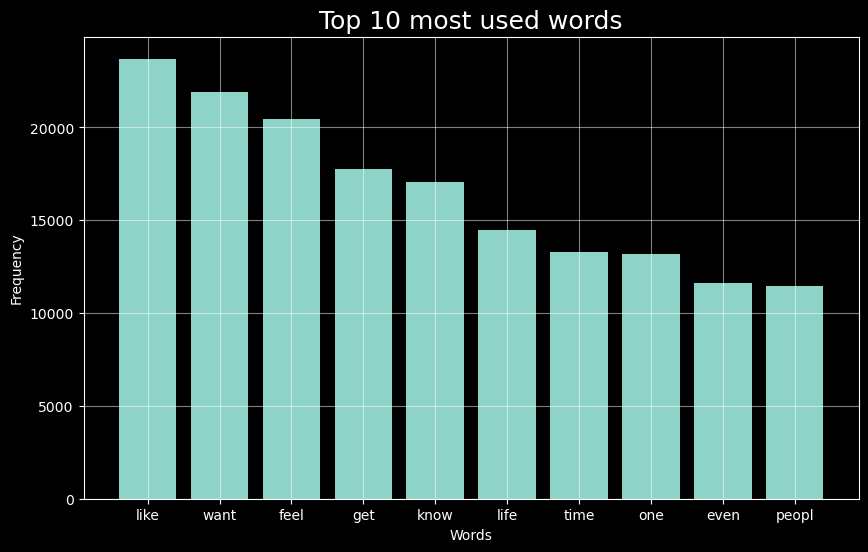

In [105]:
words = []
for text in df['clean_text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

# Figure Size and set background
plt.figure(figsize = (10, 6))
plt.style.use('dark_background')

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

# Creating a y axis with words
plt.xticks(range(len(top_words)), list(top_words.keys()))

# Grid Opacity
plt.grid(alpha = 0.5)
# Title and labels
plt.title('Top 10 most used words', fontsize = 18)
plt.xlabel('Words')
plt.ylabel('Frequency')

## ♻️ Text data pre-processing II
---

In [88]:
# Maximum number of words to be considered in the vocabulary
max_words = 10000 
# Maximum number of tokens in a sequence
max_len = 200 
# Tokenizer
tokenizer = Tokenizer(num_words = max_words) 
# Snap tokenizer to text data
tokenizer.fit_on_texts(df['text']) 
# Converts texts into strings of numbers
sequences = tokenizer.texts_to_sequences(df['text']) 
# Mapping words to indexes
word_index = tokenizer.word_index 

In [89]:
# Sequence padding
data = pad_sequences(sequences, maxlen = max_len)

In [90]:
# Converting labels to numeric format
labels = tf.keras.utils.to_categorical(df['label'])

# 🤖 Model
---

In [99]:
# Model
model = Sequential()
model.add(Embedding(max_words, 128, input_length = max_len))
model.add(Bidirectional(LSTM(64, dropout = 0.3, recurrent_dropout = 0.2)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

# Compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [102]:
# Checking summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_20 (Dense)            (None, 32)                4128      
                                                                 
 dense_21 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1,383,010
Trainable params: 1,383,010
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Fit model
history = model.fit(data, labels, validation_split = 0.2, epochs = 5, batch_size = 32)

Epoch 1/5
700/700 [==============================] - 333s 463ms/step - loss: 0.2625 - accuracy: 0.8954 - val_loss: 0.2157 - val_accuracy: 0.9196
Epoch 2/5
700/700 [==============================] - 351s 502ms/step - loss: 0.1601 - accuracy: 0.9420 - val_loss: 0.2202 - val_accuracy: 0.9119
Epoch 3/5
700/700 [==============================] - 371s 531ms/step - loss: 0.1165 - accuracy: 0.9583 - val_loss: 0.2525 - val_accuracy: 0.9114
Epoch 4/5
700/700 [==============================] - 374s 534ms/step - loss: 0.0897 - accuracy: 0.9691 - val_loss: 0.2530 - val_accuracy: 0.9049
Epoch 5/5
700/700 [==============================] - 383s 547ms/step - loss: 0.0707 - accuracy: 0.9760 - val_loss: 0.3146 - val_accuracy: 0.9105


# 📊 Viewing the results
---

## Loss graph

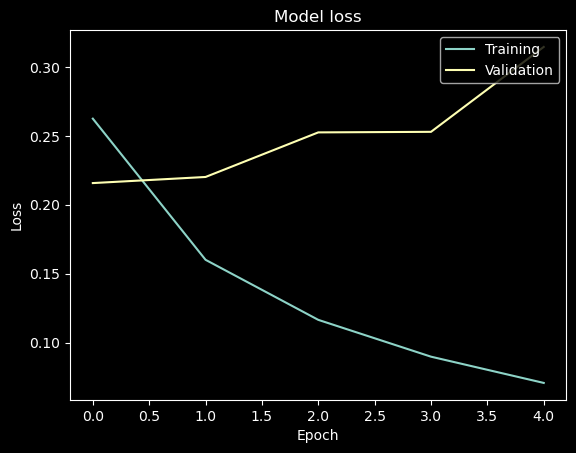

In [106]:
# Loss graph
plt.style.use('dark_background')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.show()

## Accuracy graph

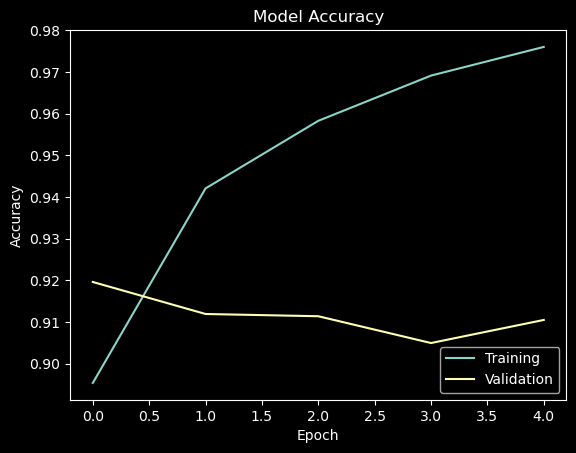

In [107]:
# Accuracy graph
plt.style.use('dark_background')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'lower right')
plt.show()

---
# 🏁 Thank you! Feel free to criticize! 🏁
---